In [ ]:
import ee
import datetime
import geojson
import geetools
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='spatiotemporal-dataset')

In [ ]:
# Mengimpor file GeoJSON dan menyimpannya ke dalam GeoDataFrame
ID_FILE_GEOJSON = '107NpG1IVYETO8tFl6-CMjhmEdanyu8YQ' # Kota Bandung
gdf = gpd.read_file(f'https://drive.google.com/uc?export=view&id={ID_FILE_GEOJSON}')

<Axes: >

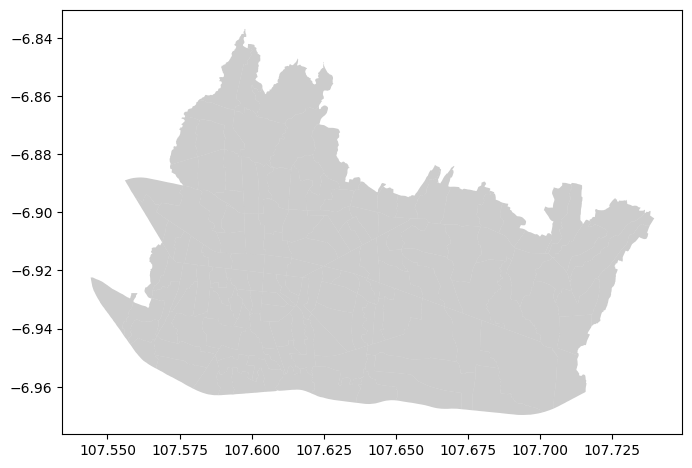

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
gdf.plot(ax=ax, alpha=0.4, color='grey')

In [ ]:
gdf.head()

,id,desa,kecamatan,kota,geometry
0,1,Maleber,Andir,Kota Bandung,"MULTIPOLYGON (((107.57671 -6.90645, 107.57671 ..."
1,2,Campaka,Andir,Kota Bandung,"MULTIPOLYGON (((107.56843 -6.89709, 107.56833 ..."
2,3,Ciroyom,Andir,Kota Bandung,"MULTIPOLYGON (((107.58909 -6.91384, 107.58918 ..."
3,4,Dunguscariang,Andir,Kota Bandung,"MULTIPOLYGON (((107.58340 -6.91106, 107.58340 ..."
4,5,Garuda,Andir,Kota Bandung,"MULTIPOLYGON (((107.57903 -6.90814, 107.57903 ..."


In [ ]:
# Iterasi melalui setiap baris dalam geodataframe
for index, row in gdf.iterrows():
    # Periksa jika geometri adalah MultiPolygon
    if row['geometry'].geom_type == 'MultiPolygon':
        # Terapkan buffer untuk mengubah MultiPolygon menjadi Polygon
        new_geometry = row['geometry'].buffer(0)
        # Simpan kembali geometri ke dalam geodataframe
        gdf.at[index, 'geometry'] = new_geometry

In [ ]:
gdf.head()

,id,desa,kecamatan,kota,geometry
0,1,Maleber,Andir,Kota Bandung,"POLYGON ((107.57671 -6.90645, 107.57671 -6.906..."
1,2,Campaka,Andir,Kota Bandung,"POLYGON ((107.56843 -6.89709, 107.56833 -6.897..."
2,3,Ciroyom,Andir,Kota Bandung,"POLYGON ((107.58909 -6.91384, 107.58918 -6.913..."
3,4,Dunguscariang,Andir,Kota Bandung,"POLYGON ((107.58340 -6.91106, 107.58340 -6.911..."
4,5,Garuda,Andir,Kota Bandung,"POLYGON ((107.57903 -6.90814, 107.57903 -6.908..."


In [ ]:
# Definisikan tanggal dan koleksi data
start_date = '2021-01-01'
end_date = '2022-12-31'

# Definisikan koleksi NTL
ntl_collection = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")

In [ ]:
# Fungsi untuk mendapatkan data sebagai Dictionary
def get_avg_rad(image):
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    avg_rad = image.reduceRegion(reducer=ee.Reducer.median(), geometry=aoi, scale=500).get('avg_rad')
    return ee.Feature(None, {'date': date, 'avg_rad': avg_rad})

In [ ]:
# Buat list untuk menampung data dari setiap pengulangan
all_data = []

# Loop melalui setiap baris dalam geodataframe dengan tqdm
for index, row in tqdm(gdf.iterrows(), total=len(gdf), desc="Processing"):
    id = row['id']
    desa = row['desa']
    kecamatan = row['kecamatan']
    kota = row['kota']
    geometry = row['geometry']

    aoi_coords = geometry.exterior.coords
    new_list = [[coord[0], coord[1]] for coord in aoi_coords]
    aoi = ee.Geometry.Polygon(new_list)

    # Filter koleksi NTL berdasarkan wilayah dari GeoJSON
    ntl_desa = ntl_collection.filterBounds(aoi)

    # Mendapatkan data sebagai koleksi Feature
    data_list = ntl_desa.filterDate(ee.Date(start_date), ee.Date(end_date)).map(get_avg_rad)

    # Konversi koleksi Feature menjadi sebuah daftar Python
    data_list = data_list.getInfo()['features']

    # Ekstrak nilai avg_rad dari daftar fitur
    avg_rad_list = [{'id': id, 'desa': desa, 'kecamatan': kecamatan, 'kota': kota, 'date': feature['properties']['date'], 'avg_rad': feature['properties']['avg_rad']} for feature in data_list]

    # Tambahkan data ke list yang lebih besar
    all_data.extend(avg_rad_list)

# Buat DataFrame dari seluruh data
df = pd.DataFrame(all_data)

# Simpan DataFrame ke dalam file CSV
output_csv = 'NTL_Kota_Bandung.csv'
df.to_csv(output_csv, index=False)

# Unduh file CSV
files.download(output_csv)

Processing: 100%|██████████| 139/139 [01:09<00:00,  2.01it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>